# Description
## Tasks
1. Action scaling, obs scaling, reward scaling (looks good for now but will reconsider this latter)
2. Stochasity of env (modify policy functions)
3. hyperparameter tuning
    1. Soft and hard target network update parameters (tau, alpha, beta, lr)
    2. Network archotecture (layers, neurons, activations, loss func)
    3. weight initilalization
    4. Batch size for memory buffer (For now batch size is set to 1 which is not enough, increase batch size to 64 at elast and train algorihim for at elast 10xbatch_size steps)
    5.Add exploration by adding gaussian noise
4. Rewrad function (include IL, pool value and other metrics, roi, liquidity utilization) 
Explore sparse and delayed rewrds to handle mutiple positions
5. Redefine obs space(For start just add balance of token0, balance of token1, tvlUSD, and latter consider Include tick, position data)
6. Predict the trained model with real data of uniswap pools (make action sapce scaling/clipping compliant with this req)
7. Add visulazations for actions and rewards during training to better understand the learning process
### Action space
Currently we are forcing that price_lower<curr_price and price upper>curr_price but it is not efficient as we are not enalbing agent to place limit orders (where both price_lower and price_upper are below are above the current price whcih doesn't make sense now as we are not including IL in our rewrard function). To handle this issue when we will incorporate IL in our reward function one of following two approaches could be used:
#### Negative rewrad approach (Ideal)
sepcify upper and lower bounds of actions around curr_price but dont need to scale action around curr_price (we are doing this to ensure that actions are valid price_lower!>price_upper) as it will make it impossible for agent to place limit orders. to handle this issue we can introduce a big negative reward in our step functions for invalid functions and terminate the episode to avoid learning instability due to big negative reward
Change activation of output layer to tanh from sigmoid
price_lower=c_p - c_p*a_0
price_upper=c_p +c_p*a_1
clipp price_lower and price_upper by min and max bounds

if price_lower > price_upper:
        return self.state, -BIG_PENALTY, True, {}
#### Parameterizing Actions with a Base and Offset (doesn't make sense)
For example: base_price is predicted directly by the network.
offset is predicted by the network but constrained to be positive (e.g., using a softplus activation function).
Then:
scaled_base_price=min_price+(max_price−min_price)×raw_base_price
scaled_offset=(2×raw_offset−1)×max_offset
price_lower=scaled_base_price−scaled_offset/2
price_upper=scaled_base_price+scaled_offset/2

### Obs space
0. Add a feature which depicts liquidity distribution around current tick instaed of giving complete data of ticks/positions in obs space. Engineeer a feature which does reflects distribution of liq in the pool
1. feehrowth0 and feegrowth1 is already representing the swaps so no need to add swap data
2. liquidity variable is representing the mint and burn events (regardless of position) so adding tick data will give him info about range of liquidity added which will make obs sapce more rich and learn complex dynamcis of pool (slippage, fee share, etc)
#### Relative change feature ((curr_value-previous_value)/previous_value)
instead of using absoulte value use of relative features ((curr_value-previous_value)/previous_value) ensures that model learns relatioship between changes in features instead of focusing on their absolute values. The problem with current obs space is that we are losing absoulte info specifically  (liq and fee growth), which could be crucial for agent to learn dynamics of differnt type of pools. e.g a pool with lower liqudity dpeth has differnt dynamics than a pool with higher liqudity depth but by enginering this relative liquidity parameter we are lsoing that information which could be crucial.
#### Running Statistics and Z-Score Scaling (mean_std deviation)
It provides the agent with information about both the absolute levels and deviations from the mean of each feature.
It allows you to control the scale of the observations using parameters like alpha for EWMA and clipping to keep values within a specific range.
Use ewma features which capture the secure the information of absolute features

# issues to address
Restricting agent to produce actions around curr price is not a good approach. Can there be any approach in which we can avoid invalid actions produced by agent without giving him a negative reward, as this will elongate the learning process of agent by mutiple times. Any other solution of avoiding invalid actions without restricting him to provide liquiidty around current price
1. Obs space engineerd features are causing the loss of absoulte information which could be crucuial for agnet to learn dynamics of differnt type of pools (add absolute info features)
3. Instaed of forcing price_lower <price_upper in action space use any of two above mentioned action scaling approaches
2. change unnormaized reward to base 128 instaed of abse 18

## Baseline Models to comapre startegies
0. Random agent which takes random actions can be used as baseline of start
1. +-10% around current price (retail_aggressive)
2. +-20% around current price (retail_safe)
3. grid strategy (x amount divided in y levels of +-10%, 15%, 20% around current price with amount expoennetially decreasing as position gets wider )

## Mulriple positions
Explore sparse and delayed rewards
1. To handle mutiple positions we can use output layer which outputs multiple actions with probabilities e.g range x1,y1 0.6, x2,y2 0.3 etc
2. Using mutiple agents, each initialized with differnt type of state space and action space (applying differnt constraints on action for aggresive and defensive actions)

## More dynamic env setup
At start of each episode we can initialze new pool with differnt dynamics (initial price, liq depth, volatility, types of assets, fees structure etc) to capture more real world pool dynamics. This will help agent to learn more generic policy, for diffrent type of pools(low/high depth, stable/volatile asset pools etc)
Sync pool is necessary to apply this approach of differnt pool in each episode
To simulate differnt dynamics in each pool, we can initilize each pool with differnt type of assets(satble, volatile), fees (0.3%, 0.1%, 1%) and also using abm to initialze pool before feeding to RL agent (initialize a new pool and then simulate it for (100/200/300) steps to capture differnt types of dynamics of pool and can also customize policies for differnt types of pools). Because A pool 10 days old has differnt dynamics than 1000 dyas old pool and A pool with x Liquidty depth has differnt dynamics than a pool with y liq depth..........

# Setup

In [1]:
import os
os.chdir('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice')
os.environ["PATH"] += ":."

In [ ]:
# run ganache and compile contracts using tsp coomand line interface
''''
import subprocess

result = subprocess.run("tsp ganache", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(f'Standard Output:\n{result.stdout}')
print(f'Standard Error:\n{result.stderr}')

result = subprocess.run("tsp compile", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(f'Standard Output:\n{result.stdout}')
print(f'Standard Error:\n{result.stderr}')
'''

In [2]:
from netlists.uniswapV3.netlist import SimStrategy,SimState,netlist_createLogData

sim_strategy = SimStrategy()


sim_state = SimState(ss=sim_strategy)


from engine.SimEngine import SimEngine

output_dir = "model_outdir_csv"
netlist_log_func = netlist_createLogData

engine = SimEngine(sim_state, output_dir, netlist_log_func)


Existing pool:WETH_USDC_3000 having pool address: 0xE0460B8E4Bd835990cd808A795F1d8D8f0BC9AC7 loaded
mnemonic: 'once transfer agent brave much risk twelve budget wife rich draft hunt'
mnemonic: 'neck brain dish dinosaur slab unique alter great inject hello spy wage'


# Imports

In [7]:
#Why this is taking a lot of time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt


import stable_baselines3
from stable_baselines3 import PPO
import gym
from gym import spaces
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete,Space
from util.constants import GOD_ACCOUNT
from util.globaltokens import weth_usdc_pool
from util.base18 import toBase18, fromBase18,fromBase128,price_to_valid_tick 

# Test netlists simulation

In [ ]:
import subprocess

cmd = "rm -rf model_outdir_csv; tsp run netlists/uniswapV3/netlist.py model_outdir_csv"
result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(f'Standard Output:\n{result.stdout}')
print(f'Standard Error:\n{result.stderr}')

In [6]:
#weth_usdc_pool.swap_token0_for_token1(GOD_ACCOUNT, toBase18(0.01), data=b'')
#weth_usdc_pool.get_global_state()

engine.run()

No positions found for this liquidity provider 0x83238490e16723444Fd21A304893186363E48d28 in pool.
Policy returned None, no action will be taken by retail_lp wallet: 0x83238490e16723444Fd21A304893186363E48d28 at this timestep.
amount_swap:740877472567728640 ,contract_token0 _balance: 16591274732949905399 ,contract_token1_balance: 58796462347361649111037
{'Transfer': [OrderedDict([('from', '0x4bc0AE6806257DE91D811B718D0671F003B52285'), ('to', '0xa661c0cD0827579B71d39B5F7b7B9f73921af6C1'), ('value', 1762272148604036363461)])], 'Swap': [OrderedDict([('sender', '0xa661c0cD0827579B71d39B5F7b7B9f73921af6C1'), ('recipient', '0xa661c0cD0827579B71d39B5F7b7B9f73921af6C1'), ('amount0', 740877472567728640), ('amount1', -1762272148604036363461), ('sqrtPriceX96', 3842272710336696909372618033427), ('liquidity', 2521453254908269010000), ('tick', 77633)])]}
{'Mint': [OrderedDict([('sender', '0x83238490e16723444Fd21A304893186363E48d28'), ('owner', '0x83238490e16723444Fd21A304893186363E48d28'), ('tickLow

# Test ENv

In [ ]:
def test_env(episodes,env):
    #Test environemnt
    episodes = episodes
    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        score = 0 
        
        while not done:
            action = env.action_space.sample()
            n_state, reward, done, info = env.step(action)
            score+=reward
        print('Episode:{} Score:{}'.format(episode, score))
    env.close()

# Fully defined action and observation space absed on logged data CSV

In [ ]:
def preprocessing_data():
  # Instead of getting data from csv file get this data directly from pool using pool's get_position, get_tick and global state functions 
    
    data_df = pd.read_csv('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/outdir_csv/data.csv')
    events_log_df = pd.read_csv('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/outdir_csv/events_log.csv')
    position_data_df = pd.read_csv('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/outdir_csv/position_data.csv')
    tick_data_df = pd.read_csv('/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/outdir_csv/tick_data.csv')


    #global_state_data = data_df.drop(columns=['Tick', 'Second', 'Min', 'Hour', 'Day'])
    global_state_data = data_df.iloc[-1:]
    
    global_state_data.astype(float)
    
    # Filter events_log.csv to get only the "Swap" events and calculate net data of swaps
    swap_events = events_log_df[events_log_df['Event Type'] == 'Swap']
    if 'amount1' in swap_events.columns:
        swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')
        net_swaps = swap_events['amount1'].abs().sum()
    else:
        net_swaps = 0
    # Drop unnecessary columns for position_data and tick_data
    df_position_clean = position_data_df.drop(columns=['Unnamed: 0','Unnamed: 1','liquidity_provider','position_key'])
    df_tick_clean = tick_data_df.drop(columns=['Unnamed: 0','Unnamed: 1','tickBitmap'])

    # Convert columns to appropriate numeric types for position_data
    cols_to_convert_position = [
        '_liquidity_raw', 
        'feeGrowthInside0LastX128', 
        'feeGrowthInside1LastX128', 
        'tokensOwed0_raw', 
        'tokensOwed1_raw'
    ]
    df_position_clean[cols_to_convert_position] = df_position_clean[cols_to_convert_position].apply(pd.to_numeric, errors='coerce')

    # Convert columns to appropriate numeric types for tick_data
    cols_to_convert_tick = [
        'liquidityGross_raw', 
        'liquidityNet_raw', 
        'feeGrowthOutside0X128', 
        'feeGrowthOutside1X128'
    ]
    df_tick_clean[cols_to_convert_tick] = df_tick_clean[cols_to_convert_tick].apply(pd.to_numeric, errors='coerce')

    # Handle any NaN values by filling them with zeros
    df_position_clean = df_position_clean.fillna(0)
    df_tick_clean = df_tick_clean.fillna(0)

    # Normalize all the features
    #scaler = MinMaxScaler()
    #df_position_normalized = pd.DataFrame(scaler.fit_transform(df_position_clean.drop(columns=['Unnamed: 1', 'liquidity_provider'])), columns=df_position_clean.drop(columns=['Unnamed: 1', 'liquidity_provider']).columns)
    #df_tick_normalized = pd.DataFrame(scaler.fit_transform(df_tick_clean), columns=df_tick_clean.columns)

    return df_position_clean, df_tick_clean, global_state_data,net_swaps

df_position_normalized, df_tick_normalized,global_state_data,net_swaps=preprocessing_data()
position_columns=df_position_normalized.columns
tick_columns=df_tick_normalized.columns

/tmp/ipykernel_20290/3389155064.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')


In [ ]:
global_state_data.head()
df_position_normalized.head()

,tick_lower,tick_upper,_liquidity_raw,feeGrowthInside0LastX128,feeGrowthInside1LastX128,tokensOwed0_raw,tokensOwed1_raw
0,75480,76500,6.379481e+21,0.0,0.0,0,0
1,75240,76980,4.736852e+21,0.0,0.0,0,0
2,74940,77400,4.171466e+21,0.0,0.0,0,0
3,74700,77820,3.882399e+21,0.0,0.0,0,0
4,74400,78240,3.713437e+21,0.0,0.0,0,0


In [ ]:
import pandas as pd
import numpy as np
from gym.spaces import Dict, Box

def create_obs_space():
    position_data_df,tick_data_df,global_state_data,net_swaps= preprocessing_data()
    # Load the CSV files
    
    # Prepare position_data.csv and tick_data.csv
    position_data_dict = position_data_df.to_dict(orient='list')
    tick_data_dict = tick_data_df.to_dict(orient='list')
    global_state_data_dict = global_state_data.to_dict(orient='list')

    
    position_data_dict = {k.strip(): v for k, v in position_data_dict.items()}
    tick_data_dict = {k.strip(): v for k, v in tick_data_dict.items()}
    global_state_data = {k.strip(): (v.strip() if isinstance(v, str) else v) for k, v in global_state_data_dict.items()}
    
    # Create the Gym observation space
    observation_space = Dict({
        'global_state': Dict({key: Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32) for key in global_state_data.keys()}),
        'net_swaps': Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
        'position_state': Dict({key: Box(low=-np.inf, high=np.inf, shape=(len(value),), dtype=np.float32) for key, value in position_data_dict.items()}),
        'tick_state': Dict({key: Box(low=-np.inf, high=np.inf, shape=(len(value),), dtype=np.float32) for key, value in tick_data_dict.items()})
    })
    
    return observation_space

In [ ]:
observation_space=create_obs_space()
#observation_space.sample()

/tmp/ipykernel_20290/3389155064.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')


In [ ]:
#Should pass lp_positions of agent as input so that it can select position to reomve from those active positions
class CustomActionSpace(Space):
    def __init__(self, min_tick, max_tick, lp_budget):
        super().__init__(shape=(1,), dtype=object)
        self.min_tick = min_tick
        self.max_tick = max_tick
        self.lp_budget = lp_budget
        self.action_types = ['do_nothing', 'add_liq', 'remove_liq']

    def sample(self):
        action_type = np.random.choice(self.action_types)

        if action_type == 'do_nothing':
            return {'action_type': 'do_nothing'}
        
        elif action_type == 'add_liq':
            tick_lower = np.random.randint(self.min_tick, self.max_tick)
            tick_upper = np.random.randint(tick_lower, self.max_tick)
            amount_usd = np.random.randint(0, self.lp_budget)
            return {'action_type': 'add_liq', 'amount_usd': amount_usd, 'tick_lower': tick_lower, 'tick_upper': tick_upper}

        elif action_type == 'remove_liq':
            tick_lower = np.random.randint(self.min_tick, self.max_tick)
            tick_upper = np.random.randint(tick_lower, self.max_tick)
            amount_liq = np.random.randint(0, self.lp_budget)
            return {'action_type': 'remove_liq', 'amount_liq': amount_liq, 'tick_lower': tick_lower, 'tick_upper': tick_upper}

    def contains(self, x):
        #Add condition for reomve liq so that reomve liq position should not be an invalid position
        if not isinstance(x, dict):
            return False
        if 'action_type' not in x:
            return False

        action_type = x['action_type']

        if action_type == 'do_nothing':
            return True
        elif action_type in ['add_liq', 'remove_liq']:
            if all(key in x for key in ['amount_usd', 'tick_lower', 'tick_upper']):
                return (self.min_tick <= x['tick_lower'] < x['tick_upper'] <= self.max_tick) and \
                    (0 <= x['amount_usd'] <= self.lp_budget)
        return False


# Test the custom action space
min_tick = -88705
max_tick = -min_tick
lp_budget = 50

action_space = CustomActionSpace(min_tick, max_tick, lp_budget)

In [ ]:
action_space.sample()

{'action_type': 'add_liq',
 'amount_usd': 9,
 'tick_lower': 54249,
 'tick_upper': 77298}

# Custom Envs based on fully defined action and obs space

In [ ]:
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()

        # Action space
        self.action_space = CustomActionSpace(min_tick, max_tick, lp_budget)
        self.observation_space = create_obs_space()
        
        self.reset()
    def step(self, action):
        obs = self.get_state()
        action_type=action['action_type']

        if action_type=='do_nothing':
            print('rl agent hloding position')

        elif action_type=='add_liq':
            tick_lower=action['tick_lower']
            tick_upper=action['tick_upper']
            amount=action['amount_usd']
            self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        elif action_type=='remov_liq':
            tick_lower=action['tick_lower']
            tick_upper=action['tick_upper']
            amount_liq=action['amount_liq']
            weth_usdc_pool.remove_liquidity(tick_lower,tick_upper,amount_liq)

        
        #reward = calculate_reward() # Calculate reward
        done = False  # Check if episode is done
        reward=10
        info={}
        return obs, done,reward,info

    def reset(self):
        df_position_clean, df_tick_clean, global_state_data, net_swaps = preprocessing_data()
        
        # Use the data to populate the initial state
        initial_state = {
            'position_state': {col: df_position_clean[col].values for col in df_position_clean.columns},
            'tick_state': {col: df_tick_clean[col].values for col in df_tick_clean.columns},
            'global_state': {col: global_state_data[col].values[0] if global_state_data[col].values.size > 0 else np.nan for col in global_state_data.columns},
            'net_swaps': np.array([net_swaps])
          } 
        return initial_state
    
    def get_state(self):
    # Similar to your preprocessing_data() but designed to get the current state
        df_position_clean, df_tick_clean, global_state_data, net_swaps = preprocessing_data()
        
        # Populate the state using the real data
        current_state = {
            'position_state': {col: df_position_clean[col].values for col in df_position_clean.columns},
            'tick_state': {col: df_tick_clean[col].values for col in df_tick_clean.columns},
            'global_state': {col: global_state_data[col].values[0] if global_state_data[col].values.size > 0 else np.nan for col in global_state_data.columns},
            'net_swaps': np.array([net_swaps])
        }
        return current_state
    def calculate_reward():
        pass


In [ ]:
env=CustomEnv()

/tmp/ipykernel_20290/3389155064.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')
/tmp/ipykernel_20290/3389155064.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')


In [ ]:
#Test environemnt
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

/tmp/ipykernel_20290/3389155064.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')
/tmp/ipykernel_20290/3389155064.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swap_events['amount1'] = pd.to_numeric(swap_events['amount1'], errors='coerce')

KeyboardInterrupt



# Discrete Env

In [ ]:
import gym
from gym import spaces

class DiscreteEnv(gym.Env):
    def __init__(self, df_position_normalized, df_tick_normalized):
        super(CustomEnv, self).__init__()

        self.df_position = df_position_normalized.values  # Convert to numpy array
        self.df_tick = df_tick_normalized.values 
        
        
        self.action_space=Discrete(3)
        self.reward=0
        self.observation_space = gym.spaces.Dict({
            'position_data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=self.df_position.shape, dtype=np.float32),
            'tick_data': gym.spaces.Box(low=-np.inf, high=np.inf, shape=self.df_tick.shape, dtype=np.float32),
            'curr_price': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'curr_liq': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'volume_usd': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'price_volatility': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        })

    def reset(self):
        # Reset the state of the environment to an initial state
        self.state = self.observation_space.sample()
        return self.state

    def step(self, action):
        #These dfs should have updated data of pool at each step 
        obs = {
            'position_data': self.df_position,  # Replace with appropriate data for the current step
            'tick_data': self.df_tick,  # Replace with appropriate data for the current step
            'curr_price': np.array([1000.0]),  # Placeholder
            'curr_liq': np.array([2000.0]),  # Placeholder
            'volume_usd': np.array([3000.0]),  # Placeholder
            'price_volatility': np.array([0.05])  # Placeholder
        }
        # Execute agent's action using pool's interface of add/remove liquidity
        self._take_action(action)
        
        # run uniswap abm env of n_steps
        # tsp run netlists  and get new state files() using preprocessing data function
        self.reward += self._calculate_reward()

        self.state=obs

        # Assume the episode is done after some arbitrary condition
        done = self._is_done()
        
        return self.state, self.reward, done, {}

    def _take_action(self, action):
        action_type = action
        
        if action_type == 0:
            # Do not change the state
            pass
        
        elif action_type == 1:
            tick_lower = 1400#action['tick_lower']
            tick_upper = 2400#action['tick_upper']
            amount = 2000#action['amount_usd']
            add_liq=[1900,2000,1200]
            
            self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')
        
        elif action_type == 2:
            tick_lower = 1400#action['tick_lower']
            tick_upper = 2400#action['tick_upper']
            amount = 2000#action['amount_usd']
            remove_liq=[1900,2000,1200]
            
            self.pool.remove_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount)


    def _calculate_reward(self):
        # get fee collected by agent 
        # self.pool.collect()
        # from pool value from previous state to this state get IL
        return 10

    def _is_done(self):
        # Implement your episode termination logic here
        
        if self.reward>50:
            return True
        else:
            self.reward+=10
            return False

# Implement your CustomActionSpace class here


In [ ]:
env = CustomEnv(df_position_normalized,df_tick_normalized)

In [ ]:
#Test environemnt
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Transaction sent: 0xa8658ffeb5c6787bfd1c9ae9dab07fdcfda58740116f7fb8e7aa037b6004ecb6
  Gas price: 8e-09 gwei   Gas limit: 5000000   Nonce: 541
  UniswapV3Pool.burn confirmed (LS)   Block: 674   Gas used: 40630 (0.81%)

Failed to remove liquidty LS
Transaction sent: 0xecec82ebbc5d2c7a00838308703b124e748c06c3dd307f423d2eebf337824540
  Gas price: 8e-09 gwei   Gas limit: 5000000   Nonce: 542
  UniswapV3Pool.burn confirmed (LS)   Block: 675   Gas used: 40630 (0.81%)

Failed to remove liquidty LS
Transaction sent: 0x735c5c6ceb2f98696a21f6e94671269c5b5e49aaf065836a70b4c0e05a664726
  Gas price: 8e-09 gwei   Gas limit: 5000000   Nonce: 543
  UniswapV3Pool.burn confirmed (LS)   Block: 676   Gas used: 40630 (0.81%)

Failed to remove liquidty LS
Episode:1 Score:150
Transaction sent: 0x24c4f4e3a30733cedbf0f782b7d471fb4e0b4e8654ca30fb467eaae19683c9b2
  Gas price: 8e-09 gwei   Gas limit: 5000000   Nonce: 544
  UniswapV3Pool.burn confirmed (LS)   Block: 677   Gas used: 40630 (0.81%)

Failed to remove 

# Train and Evaluate agent Stablebaseline Agents

In [12]:
from stable_baselines3 import PPO

# Create environment


# Instantiate the agent
model = PPO('MultiInputPolicy', env_box, verbose=1)

# Train the agent
model.learn(total_timesteps=10)

# Evaluate the agent
obs = env_box.reset()
for i in range(5):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done:
      obs = env.reset()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


AttributeError: 'Box' object has no attribute 'spaces'

# PPO stabebaseline model with Box Spaces

In [31]:
class DiscreteSimpleEnvBox(Env):
    def __init__(self, price_lower_low, price_lower_high, price_upper_low, price_upper_high, agent_budget_usd, pool):
        super(DiscreteSimpleEnvBox, self).__init__()

        self.pool = pool
        self.global_state = self.pool.get_global_state()

        self.action_space = spaces.Box(
            low=np.array([price_lower_low, price_upper_low], dtype=np.float32),
            high=np.array([price_lower_high, price_upper_high], dtype=np.float32),
            dtype=np.float32
        )

        self.reward = 0
        self.episode_count = 0
        self.step_count = 0
        self.cumulative_reward = 0
        self.done = False

        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([np.inf, np.inf, np.inf, np.inf], dtype=np.float32),
            dtype=np.float32
        )
        self.agent_budget_usd = agent_budget_usd

    def reset(self):
        self.global_state = self.pool.get_global_state()
        self.state = np.array([
            float(self.global_state['curr_price']),
            float(self.global_state['liquidity_raw']),
            float(self.global_state['feeGrowthGlobal0X128']),
            float(self.global_state['feeGrowthGlobal1X128'])
        ], dtype=np.float32)

        self.done = False
        self.cumulative_reward = 0
        self.episode_count += 1
        self.step_count=0
        print(f"Episode: {self.episode_count}")
        
        return self.state

    def step(self, action):
        _action=self._take_action(action)
        self.state = self.get_state()
        self.reward = self._calculate_reward(action,_action)
        
        self.cumulative_reward += self.reward
        self.done = self._is_done()

        self.step_count += 1
        print(f"Step{self.step_count}_reward: {self.reward} cumulative_reward: {self.cumulative_reward}")

        return self.state, self.reward, self.done, {}

    def _take_action(self, action):
        tick_lower = price_to_valid_tick(action[0])
        tick_upper = price_to_valid_tick(action[1])
        amount = self.agent_budget_usd
        tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')
        return tx_receipt

    def get_state(self):
        #cmd = "rm -rf outdir_csv; tsp run netlists/uniswapV3/netlist.py outdir_csv"
        #result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        engine.run()

        #print(f'Standard Output:\n{result.stdout}')
        #print(f'Standard Error:\n{result.stderr}')
        
        self.global_state = self.pool.get_global_state()
        self.state = np.array([
            float(self.global_state['curr_price']),
            float(self.global_state['liquidity_raw']),
            float(self.global_state['feeGrowthGlobal0X128']),
            float(self.global_state['feeGrowthGlobal1X128'])
        ], dtype=np.float32)
        return self.state

    def _calculate_reward(self, action,_action):
        tick_lower = price_to_valid_tick(action[0], 60)
        tick_upper = price_to_valid_tick(action[1], 60)
        liquidity = _action.events['Mint']['amount']
        #liquidity = self.pool.budget_to_liquidity(tick_lower, tick_upper, amount)
        self.pool.remove_liquidity_with_liquidty(GOD_ACCOUNT, tick_lower, tick_upper, liquidity)
        _,fee_income = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper)
        
        self.reward = fee_income

        return self.reward

    def _is_done(self):
        threshold =1000 
        return self.step_count>4 or self.cumulative_reward>threshold
    
price_lower_low = 1000
price_lower_high = 2000
price_upper_low = 2000
price_upper_high = 3000
agent_budget_usd = 1000
pool = weth_usdc_pool

env_box = DiscreteSimpleEnvBox(price_lower_low, price_lower_high, price_upper_low, price_upper_high, agent_budget_usd,weth_usdc_pool)

In [32]:
# Instantiate the agent
model = PPO('MlpPolicy', env_box, verbose=0)

/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/tsp_venv/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [33]:
model.learn(total_timesteps=10)

Episode: 1


{'Mint': [OrderedDict([('sender', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('owner', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('tickLower', 69060), ('tickUpper', 76020), ('amount', 38029106218509850000), ('amount0', 0), ('amount1', 500000000000255239480)])]}
{'Mint': [OrderedDict([('sender', '0x1eE1Ded283e6fC8A46BBf5387e54f7933Db62d08'), ('owner', '0x1eE1Ded283e6fC8A46BBf5387e54f7933Db62d08'), ('tickLower', 75960), ('tickUpper', 80820), ('amount', 162481706991257550000), ('amount0', 466870961258087394), ('amount1', 695433491919976886337)])]}
amount_swap:54563877973153464
contract token0 ablance:14426575755032498245,contract token1 ablance:47960370962570487081622
{'Transfer': [OrderedDict([('from', '0x4bc0AE6806257DE91D811B718D0671F003B52285'), ('to', '0x4F9a4C220cDB260830917a8CC3b3442117159C15'), ('value', 129808311841901084104)])], 'Swap': [OrderedDict([('sender', '0x4F9a4C220cDB260830917a8CC3b3442117159C15'), ('recipient', '0x4F9a4C220cDB260830917a8CC3b3442117159C15'), ('

KeyboardInterrupt: 

In [ ]:
# Evaluate the agent
obs = env_box.reset()
for i in range(5):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    if done:
      obs = env.reset()


# DDPG Model with Dict Spaces ENv

## Dict Env

In [8]:
class DiscreteSimpleEnv(gym.Env):
    def __init__(self,agent_budget_usd,pool):
        super(DiscreteSimpleEnv, self).__init__()

        self.pool=pool
        self.global_state=self.pool.get_global_state()
        curr_price=self.global_state['curr_price']
        action_lower_bound=curr_price-curr_price*0.5
        action_upper_bound=curr_price+curr_price*0.5
        
        self.action_space=gym.spaces.Dict({
            'price_lower': gym.spaces.Box(low=action_lower_bound, high=curr_price, shape=(1,), dtype=np.float32),
            'price_upper': gym.spaces.Box(low=curr_price, high=action_upper_bound, shape=(1,), dtype=np.float32),
        })

        self.reward=0
        self.cumulative_reward = 0
        self.done=False
        self.episode=0
        self.step_count=0

        self.observation_space = gym.spaces.Dict({
            'curr_price': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'liquidity': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
            'feeGrowthGlobal0x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),
            'feeGrowthGlobal1x128': gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32),   
        })
        self.agent_budget_usd = agent_budget_usd

        # Initialize rewrad normalization running statistics
        self.reward_mean = 0
        self.reward_std = 1
        self.reward_count = 0

        # Initialize running statistics for state normalization
        self.curr_price_mean = 0
        self.curr_price_std = 1
        self.liquidity_mean = 0
        self.liquidity_std = 1
        self.fee_growth_diff_0 = 0
        self.fee_growth_diff_1 = 0
        self.fee_growth_0_mean = 0
        self.fee_growth_1_mean = 0
        self.fee_growth_0_std = 1
        self.fee_growth_1_std = 1
        self.previous_fee_growth_0 = 0
        self.previous_fee_growth_1 = 0
        self.alpha = 0.9

    def reset(self):
        # reset pool for better results episode wise learning
        obs = self.get_state()

        self.state = obs
        self.done=False
        self.reward=0
        self.cumulative_reward = 0
        self.episode+=1
        self.step_count=0
        return self.state


    def step(self, raw_action):
              
        # Execute agent's action using pool's interface of add/remove liquidity
        tx_receipt,action=self._take_action(raw_action)
        
        # run uniswap abm env of n_steps
        engine.run()
        
        self.state=self.get_state()

        self.reward,_reward = self._calculate_reward(action,tx_receipt)
        self.cumulative_reward += self.reward

        # Assume the episode is done after some arbitrary condition
        self.step_count+=1
        print()
        print(f"episode: {self.episode}, step_count: {self.step_count}, step_reward: {self.reward}, reward_raw: {_reward} cumulative_reward: {self.cumulative_reward}")
        print(f"pool_state_raw: {self.pool.get_global_state()}")
        print(f"pool_state_scaled: {self.state}")
        print()
        data_log.append((self.episode, self.step_count, action, self.pool.get_global_state(),raw_action, self.state, _reward, self.reward,self.cumulative_reward))
        self.done = self._is_done()
        return self.state, self.reward, self.done, {}

    def get_state(self):
        self.global_state = self.pool.get_global_state()

        # Scaling for curr_price and liquidity
        curr_price = float(self.global_state['curr_price'])
        liquidity = float(self.global_state['liquidity_raw'])

        self.curr_price_mean = self.alpha * curr_price + (1 - self.alpha) * self.curr_price_mean
        self.curr_price_std = np.sqrt(self.alpha * (curr_price - self.curr_price_mean)**2 + (1 - self.alpha) * self.curr_price_std**2)

        self.liquidity_mean = self.alpha * liquidity + (1 - self.alpha) * self.liquidity_mean
        self.liquidity_std = np.sqrt(self.alpha * (liquidity - self.liquidity_mean)**2 + (1 - self.alpha) * self.liquidity_std**2)

        obs = {
            'curr_price': (curr_price - self.curr_price_mean) / (self.curr_price_std + 1e-10),
            'liquidity': (liquidity - self.liquidity_mean) / (self.liquidity_std + 1e-10),
        }

        # Scaling for fee growth differences
        fee_growth_0 = float(self.global_state['feeGrowthGlobal0X128'])
        fee_growth_1 = float(self.global_state['feeGrowthGlobal1X128'])

        self.fee_growth_diff_0 = fee_growth_0 - self.previous_fee_growth_0
        self.fee_growth_diff_1 = fee_growth_1 - self.previous_fee_growth_1

        self.fee_growth_0_mean = self.alpha * self.fee_growth_diff_0 + (1 - self.alpha) * self.fee_growth_0_mean
        self.fee_growth_0_std = np.sqrt(self.alpha * (self.fee_growth_diff_0 - self.fee_growth_0_mean)**2 + (1 - self.alpha) * self.fee_growth_0_std**2)

        self.fee_growth_1_mean = self.alpha * self.fee_growth_diff_1 + (1 - self.alpha) * self.fee_growth_1_mean
        self.fee_growth_1_std = np.sqrt(self.alpha * (self.fee_growth_diff_1 - self.fee_growth_1_mean)**2 + (1 - self.alpha) * self.fee_growth_1_std**2)

        obs['feeGrowthGlobal0x128'] = (self.fee_growth_diff_0 - self.fee_growth_0_mean) / (self.fee_growth_0_std + 1e-10)
        obs['feeGrowthGlobal1x128'] = (self.fee_growth_diff_1 - self.fee_growth_1_mean) / (self.fee_growth_1_std + 1e-10)

        self.previous_fee_growth_0 = fee_growth_0
        self.previous_fee_growth_1 = fee_growth_1

        return obs

    def _take_action(self, action):
        #scale action
        price_lower = self.action_space['price_lower'].low[0] + action[0, 0].numpy() * (self.action_space['price_lower'].high[0] - self.action_space['price_lower'].low[0])
        price_upper = self.action_space['price_upper'].low[0] + action[0, 1].numpy() * (self.action_space['price_upper'].high[0] - self.action_space['price_upper'].low[0])
        
        # clip action
        price_lower = tf.clip_by_value(price_lower, self.action_space['price_lower'].low[0], self.action_space['price_lower'].high[0])
        price_upper = tf.clip_by_value(price_upper, self.action_space['price_upper'].low[0], self.action_space['price_upper'].high[0])

        action_dict = {
            'price_lower': price_lower.numpy(),
            'price_upper': price_upper.numpy()
        }
        print(f"raw_action: {action}, scaled_action{action_dict}")
        print()

        tick_lower=price_to_valid_tick(action_dict['price_lower'])
        tick_upper=price_to_valid_tick(action_dict['price_upper'])
        amount=self.agent_budget_usd

        tx_receipt=self.pool.add_liquidity(GOD_ACCOUNT, tick_lower, tick_upper, amount, b'')

        return tx_receipt,action_dict
        

    def _calculate_reward(self,action,tx_receipt):
       
        tick_lower=price_to_valid_tick(action['price_lower'],60)
        tick_upper=price_to_valid_tick(action['price_upper'],60)
        liquidity=tx_receipt.events['Mint']['amount']
        #self.pool.remove_liquidity_with_liquidty(GOD_ACCOUNT, tick_lower, tick_upper, 0)
        _,fee_income = self.pool.collect_fee(GOD_ACCOUNT, tick_lower, tick_upper)
        self.pool.remove_liquidity_with_liquidty(GOD_ACCOUNT, tick_lower, tick_upper, liquidity)
        
        #impermanent_loss = self.pool.calculate_impermanent_loss(tick_lower, tick_upper)
        #capital_efficiency = self.pool.calculate_capital_efficiency(tick_lower, tick_upper)
        #gas_cost = self.pool.estimate_gas_cost(action)
    
        _reward = fee_income #- impermanent_loss + capital_efficiency - gas_cost

        self.reward_count += 1
        new_mean = self.reward_mean + (_reward - self.reward_mean) / self.reward_count
        new_std = ((self.reward_std ** 2 + (_reward - self.reward_mean) * (_reward - new_mean)) / self.reward_count) ** 0.5

        self.reward_mean = new_mean
        self.reward_std = new_std

        self.reward = (_reward - self.reward_mean) / (self.reward_std + 1e-10)
    
      
        return self.reward,_reward

    def _is_done(self):
        
        max_threshold = 500
        min_threshold= -500  
        if self.cumulative_reward >= max_threshold or self.cumulative_reward<=min_threshold:
            return True
        else:
            return False


## Agent Model

In [10]:
class ReplayBuffer:
    def __init__(self, max_size, input_dims, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, input_dims))
        self.new_state_memory = np.zeros((self.mem_size, input_dims))
           
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):

        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1
        #print(f"action_memory:{self.action_memory}")


    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

class Actor(tf.keras.Model):
    def __init__(self, n_actions):
        super(Actor, self).__init__()

        self.fc1 = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(300, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.output_layer = tf.keras.layers.Dense(2, activation='sigmoid')  # Two output units for 'price_lower' and 'price_upper'

    def call(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        
        # Use the modified output layer
        actions = self.output_layer(x)
        
        return actions
        
class Critic(tf.keras.Model):
    def __init__(self, n_actions):
        super(Critic, self).__init__()
        self.fc1 = tf.keras.layers.Dense(400, activation='relu')
        
        self.fc2 = tf.keras.layers.Dense(300, activation='relu')
        
        self.q = tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action):
        x = tf.concat([state, action], axis=1)
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.q(x)
        return q
    
class DDPG:
    def __init__(self, alpha=0.001, beta=0.002, input_dims=[8], tau=0.005, env=None,
                 gamma=0.99, n_actions=2, max_size=1000000, layer1_size=400, 
                 layer2_size=300, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size

        self.actor = Actor(n_actions=n_actions)
        self.critic = Critic(n_actions=n_actions)

        self.target_actor = Actor(n_actions=n_actions)
        self.target_critic = Critic(n_actions=n_actions)

        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=beta))

        self.update_network_parameters(tau=1)

        self.env = env

        # For tensorboard logging
        self.log_dir = '/mnt/c/Users/hijaz tr/Desktop/cadCADProject1/tokenspice/model_storage'
        self.train_summary_writer = tf.summary.create_file_writer(self.log_dir)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic.set_weights(weights)

    def remember(self, state, action, reward, new_state, done):

        flat_state = self.flatten_state(state)
        flat_action = self.flatten_action(action)
        flat_new_state = self.flatten_state(new_state)
        self.memory.store_transition(flat_state, flat_action, reward, flat_new_state, done)
        

    def flatten_state(self,state_dict):
        curr_price = float(state_dict['curr_price'])
        liquidity = float(state_dict['liquidity'])
        fee_growth_0 = float(state_dict['feeGrowthGlobal0x128'])
        fee_growth_1 = float(state_dict['feeGrowthGlobal1x128'])
        
        return np.array([curr_price, liquidity, fee_growth_0, fee_growth_1])

    def unflatten_state(self,state_array):
        return {
            'curr_price': state_array[0],
            'liquidity': state_array[1],
            'feeGrowthGlobal0x128': state_array[2],
            'feeGrowthGlobal1x128': state_array[3]
        }

    def flatten_action(self,action):
        return tf.reshape(action, [-1])

    def unflatten_action(self,action):
        return tf.reshape(action, [1, -1])
    
    def choose_action(self, state):
        state_dict = state
        state_dict_float = {
            key: float(value) for key, value in state_dict.items()
        }

        state_array = np.array(list(state_dict_float.values()), dtype=np.float32)
        state_array = state_array.reshape(1, -1)
        state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)

        raw_actions_tensor = self.actor(state_tensor)

        # GAUSSIAN NOISE TO ENABLE EXPLORATION
        #noise = np.random.normal(loc=0, scale=0.3, size=2)
        #price_lower += noise[0]
        #price_upper += noise[1]
        
        return raw_actions_tensor

        
    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                                      self.memory.sample_buffer(self.batch_size)
        
        #print(f"{state},{action},{reward},{new_state}")
        states = tf.convert_to_tensor(state, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_state, dtype=tf.float32)
        rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
        actions = tf.convert_to_tensor(action, dtype=tf.float32)


        with tf.GradientTape() as tape:
            target_actions = self.target_actor(states_)
            critic_value_ = tf.squeeze(self.target_critic(
                                states_, target_actions), 1)
            critic_value = tf.squeeze(self.critic(states, actions), 1)
            target = rewards + self.gamma*critic_value_*(1-done)
            critic_loss = tf.keras.losses.MSE(target, critic_value)

        critic_network_gradient = tape.gradient(critic_loss, 
                                            self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(
            critic_network_gradient, self.critic.trainable_variables))

        with tf.GradientTape() as tape:
            new_policy_actions = self.actor(states)
            actor_loss = -self.critic(states, new_policy_actions)
            actor_loss = tf.math.reduce_mean(actor_loss)

        actor_network_gradient = tape.gradient(actor_loss, 
                                    self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(
            actor_network_gradient, self.actor.trainable_variables))
        
        print(f"Actor_Loss: {actor_loss.numpy()}, Critic_Loss: {critic_loss.numpy()}")
       
        with self.train_summary_writer.as_default():
            tf.summary.scalar('critic_loss', critic_loss.numpy(), step=self.memory.mem_cntr)
            tf.summary.scalar('actor_loss', actor_loss.numpy(), step=self.memory.mem_cntr)


        self.update_network_parameters()

## Initilazation

In [11]:
data_log=[]
env=DiscreteSimpleEnv(agent_budget_usd=1000,pool=weth_usdc_pool)

n_actions = sum(action_space.shape[0] for action_space in env.action_space.values())

input_dims = sum(np.prod(env.observation_space.spaces[key].shape) for key in env.observation_space.spaces.keys())

agent = DDPG(alpha=0.001, beta=0.002, input_dims=input_dims, tau=1, env=env,
             n_actions=n_actions, layer1_size=400, layer2_size=300, batch_size=5)


## Train

In [12]:
n_episodes = 1
max_steps = 100


for i in range(n_episodes):
    state = env.reset()
    episode_reward = 0
    
    for _ in range(max_steps):
        action = agent.choose_action(state)

        next_state, reward, done, _ = env.step(action)
        
        agent.remember(state, action, reward, next_state, done)
        agent.learn()

        state = next_state
        episode_reward += reward
        
        if done:
            break

    print(f"Episode {i+1}: Reward = {episode_reward}")

# agent.save_model()


raw_action: [[0.55143094 0.52469724]], scaled_action{'price_lower': 1489.7178, 'price_upper': 2424.2695}

{'Mint': [OrderedDict([('sender', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('owner', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('tickLower', 73080), ('tickUpper', 77940), ('amount', 96134431880656010000), ('amount0', 241533200193353529), ('amount1', 499999999998505731787)])]}
No positions found for this liquidity provider 0xee1a97aA22F9aCB0034824f2A198B96BE30c3732 in pool.
Policy returned None, no action will be taken by retail_lp wallet: 0xee1a97aA22F9aCB0034824f2A198B96BE30c3732 at this timestep.
{'Transfer': [OrderedDict([('from', '0xE0460B8E4Bd835990cd808A795F1d8D8f0BC9AC7'), ('to', '0x2929f706a936C7fDC4Ef769Ed5e12F62a22483Cc'), ('value', 137454097994899545)])], 'Swap': [OrderedDict([('sender', '0x2929f706a936C7fDC4Ef769Ed5e12F62a22483Cc'), ('recipient', '0x2929f706a936C7fDC4Ef769Ed5e12F62a22483Cc'), ('amount0', -137454097994899545), ('amount1', 264802781844654063616

KeyboardInterrupt: 

## Training Visulizations

In [13]:
df_data = []

for entry in data_log:
    episode, step_count, _action, global_state, tensor_data, state, _reward, reward, cumulative_reward = entry
    #raw_action_0, raw_action_1 = tensor_data[0]
    
    # Combine all data into a single dictionary
    data = {
        'episode': episode,
        'step_count': step_count,
        #'raw_action_0': raw_action_0,
        #'raw_action_1': raw_action_1,
        '_reward': _reward,
        'reward': reward,
        'cumulative_reward': cumulative_reward
    }
    
    # Add raw_action, global_state and state data
    global_state['global_curr_price'] = global_state.pop('curr_price')
    data.update(_action)
    data.update(global_state)
    data.update(state)
    
    df_data.append(data)

data_df = pd.DataFrame(df_data)

In [16]:
data_df.head()
data_df.to_csv('model_outdir_csv/rl_agent_data.csv', index=False)

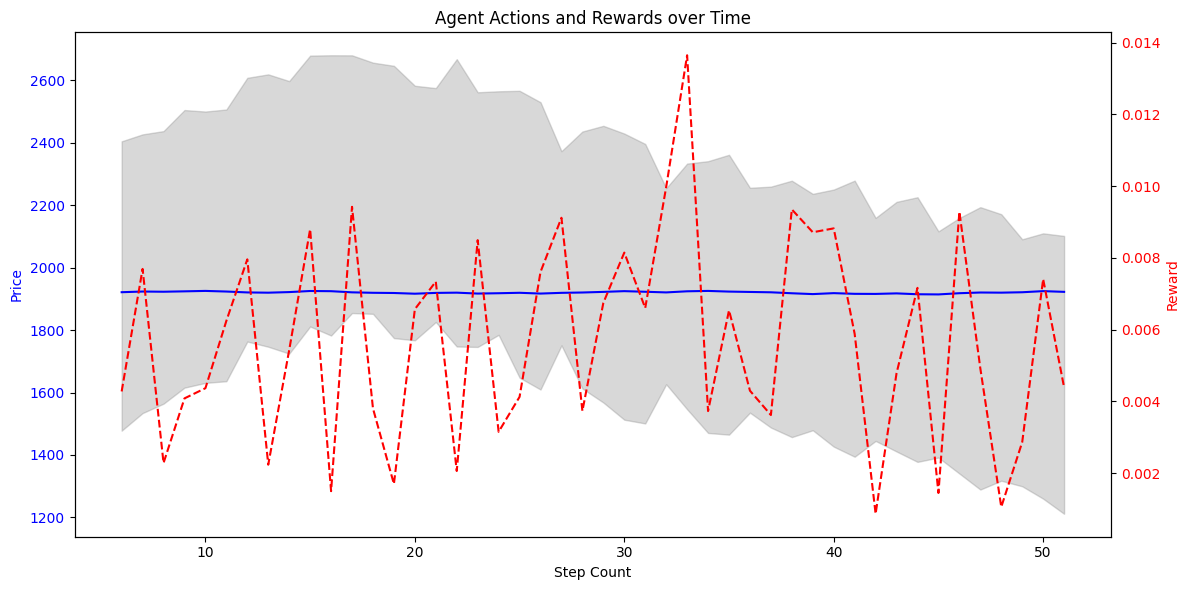

In [31]:
# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot curr_price over step_count
ax1.plot(data_df['step_count'], data_df['global_curr_price'], label='Current Price', color='blue')
ax1.fill_between(data_df['step_count'], data_df['price_lower'], data_df['price_upper'], color='gray', alpha=0.3, label='Action Range (price_lower to price_upper)')
ax1.set_xlabel('Step Count')
ax1.set_ylabel('Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for rewards
ax2 = ax1.twinx()
ax2.plot(data_df['step_count'], data_df['_reward'], label='Reward', color='red', linestyle='--')
ax2.set_ylabel('Reward', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and show plot
plt.title('Agent Actions and Rewards over Time')
fig.tight_layout()
plt.show()


/tmp/ipykernel_2119/351769843.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reward_colormap = plt.cm.get_cmap('RdYlBu_r')


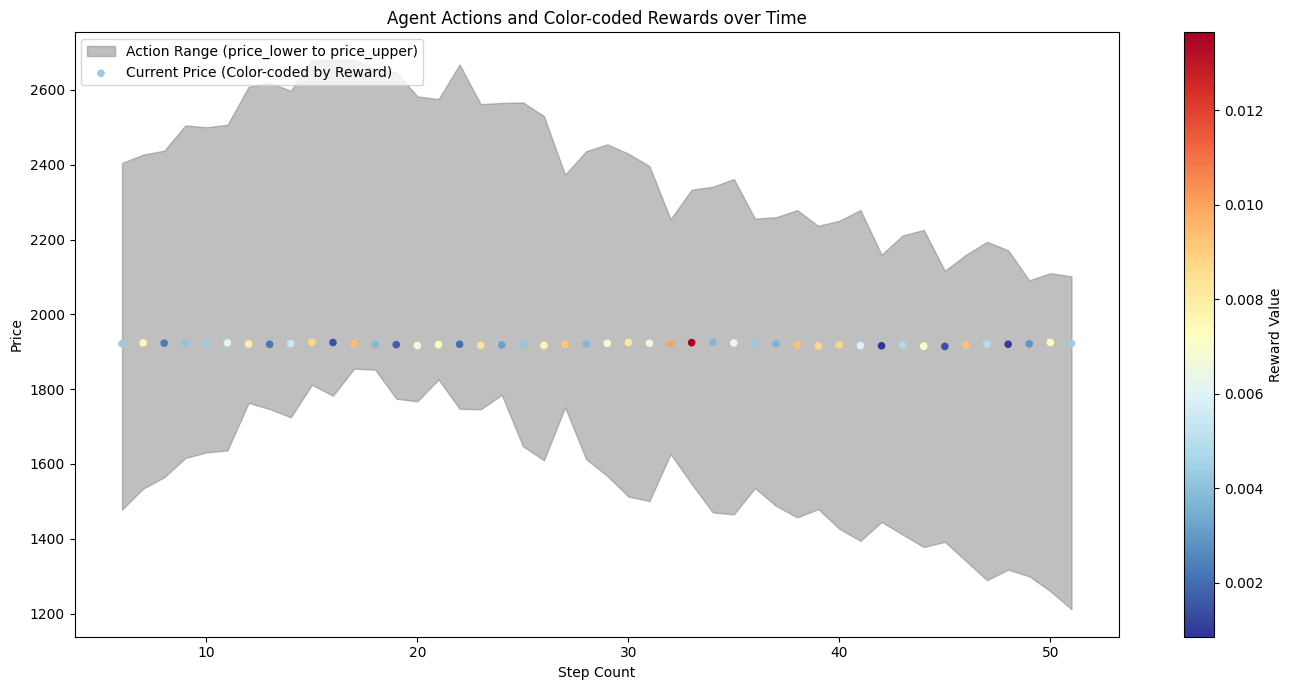

In [18]:
# Color-coding curr_price based on reward magnitude

fig, ax = plt.subplots(figsize=(14, 7))

# Create a colormap to color the curr_price line based on reward
reward_colormap = plt.cm.get_cmap('RdYlBu_r')

# Normalize the rewards for coloring
norm = plt.Normalize(data_df['_reward'].min(), data_df['_reward'].max())

# Plot the actions (price_lower and price_upper) as shaded regions
ax.fill_between(data_df['step_count'], data_df['price_lower'], data_df['price_upper'], color='gray', alpha=0.5, label='Action Range (price_lower to price_upper)')

# Plot curr_price with color-coded reward
points = ax.scatter(data_df['step_count'], data_df['global_curr_price'], c=data_df['_reward'], cmap=reward_colormap, norm=norm, s=20, label='Current Price (Color-coded by Reward)')
cbar = plt.colorbar(points, ax=ax)
cbar.set_label('Reward Value')

ax.set_xlabel('Step Count')
ax.set_ylabel('Price')
ax.set_title('Agent Actions and Color-coded Rewards over Time')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


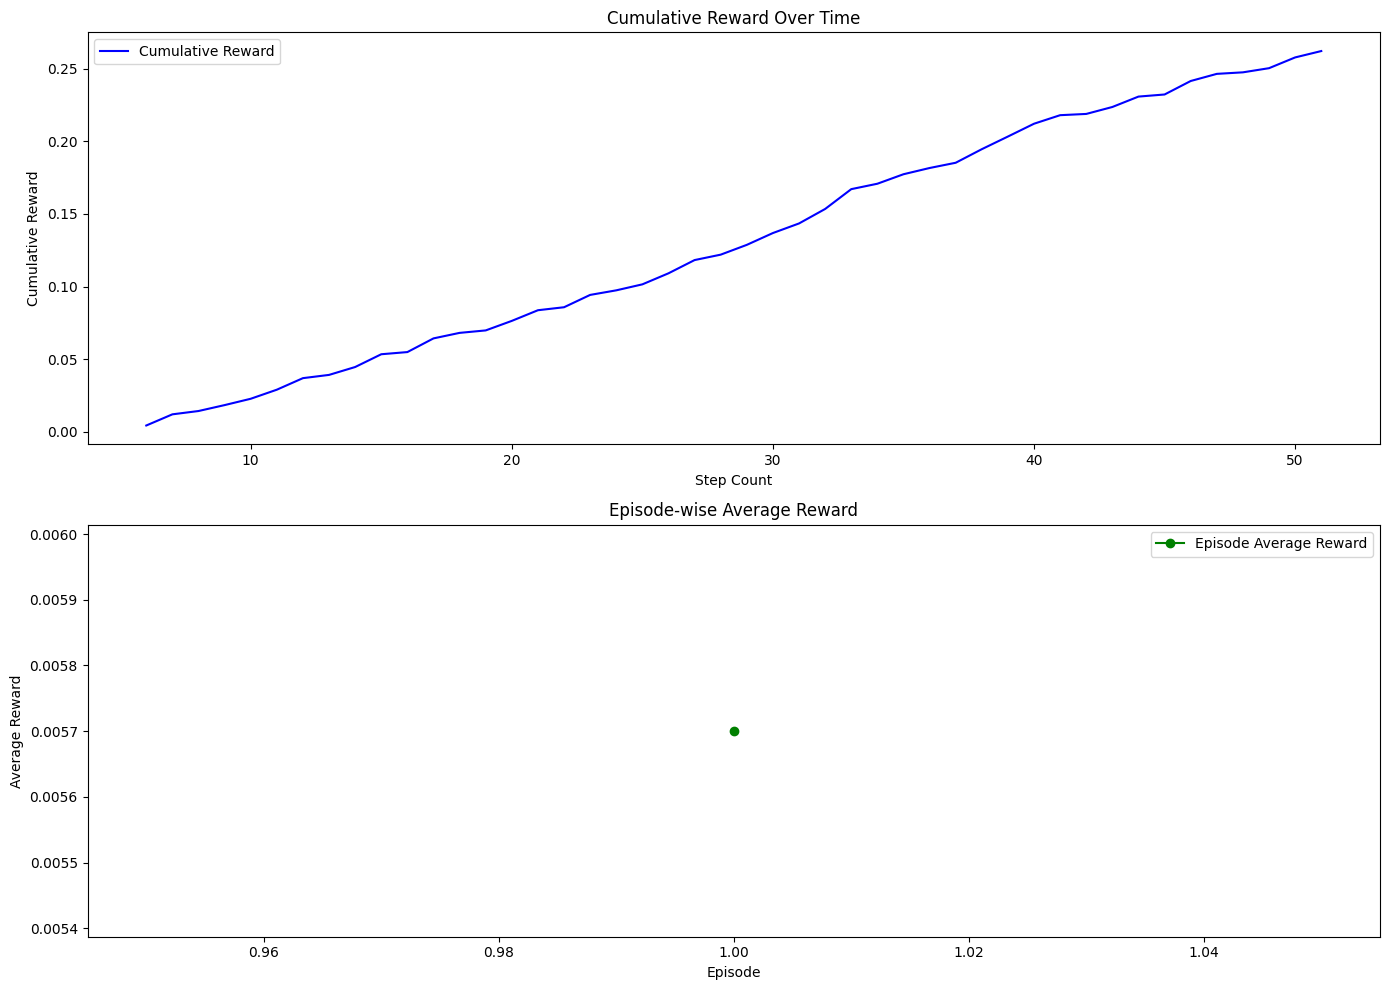

In [20]:
# Calculating cumulative reward and episode-wise average reward
new_data_df=data_df
new_data_df['cumulative_reward'] = new_data_df['_reward'].cumsum()
episode_avg_reward = new_data_df.groupby('episode').mean()['_reward']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# Plotting cumulative reward over time
axes[0].plot(new_data_df['step_count'], new_data_df['cumulative_reward'], label='Cumulative Reward', color='blue')
axes[0].set_title('Cumulative Reward Over Time')
axes[0].set_xlabel('Step Count')
axes[0].set_ylabel('Cumulative Reward')
axes[0].legend()

# Plotting episode-wise average reward
axes[1].plot(episode_avg_reward.index, episode_avg_reward.values, label='Episode Average Reward', color='green', marker='o')
axes[1].set_title('Episode-wise Average Reward')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Average Reward')
axes[1].legend()

plt.tight_layout()
plt.show()


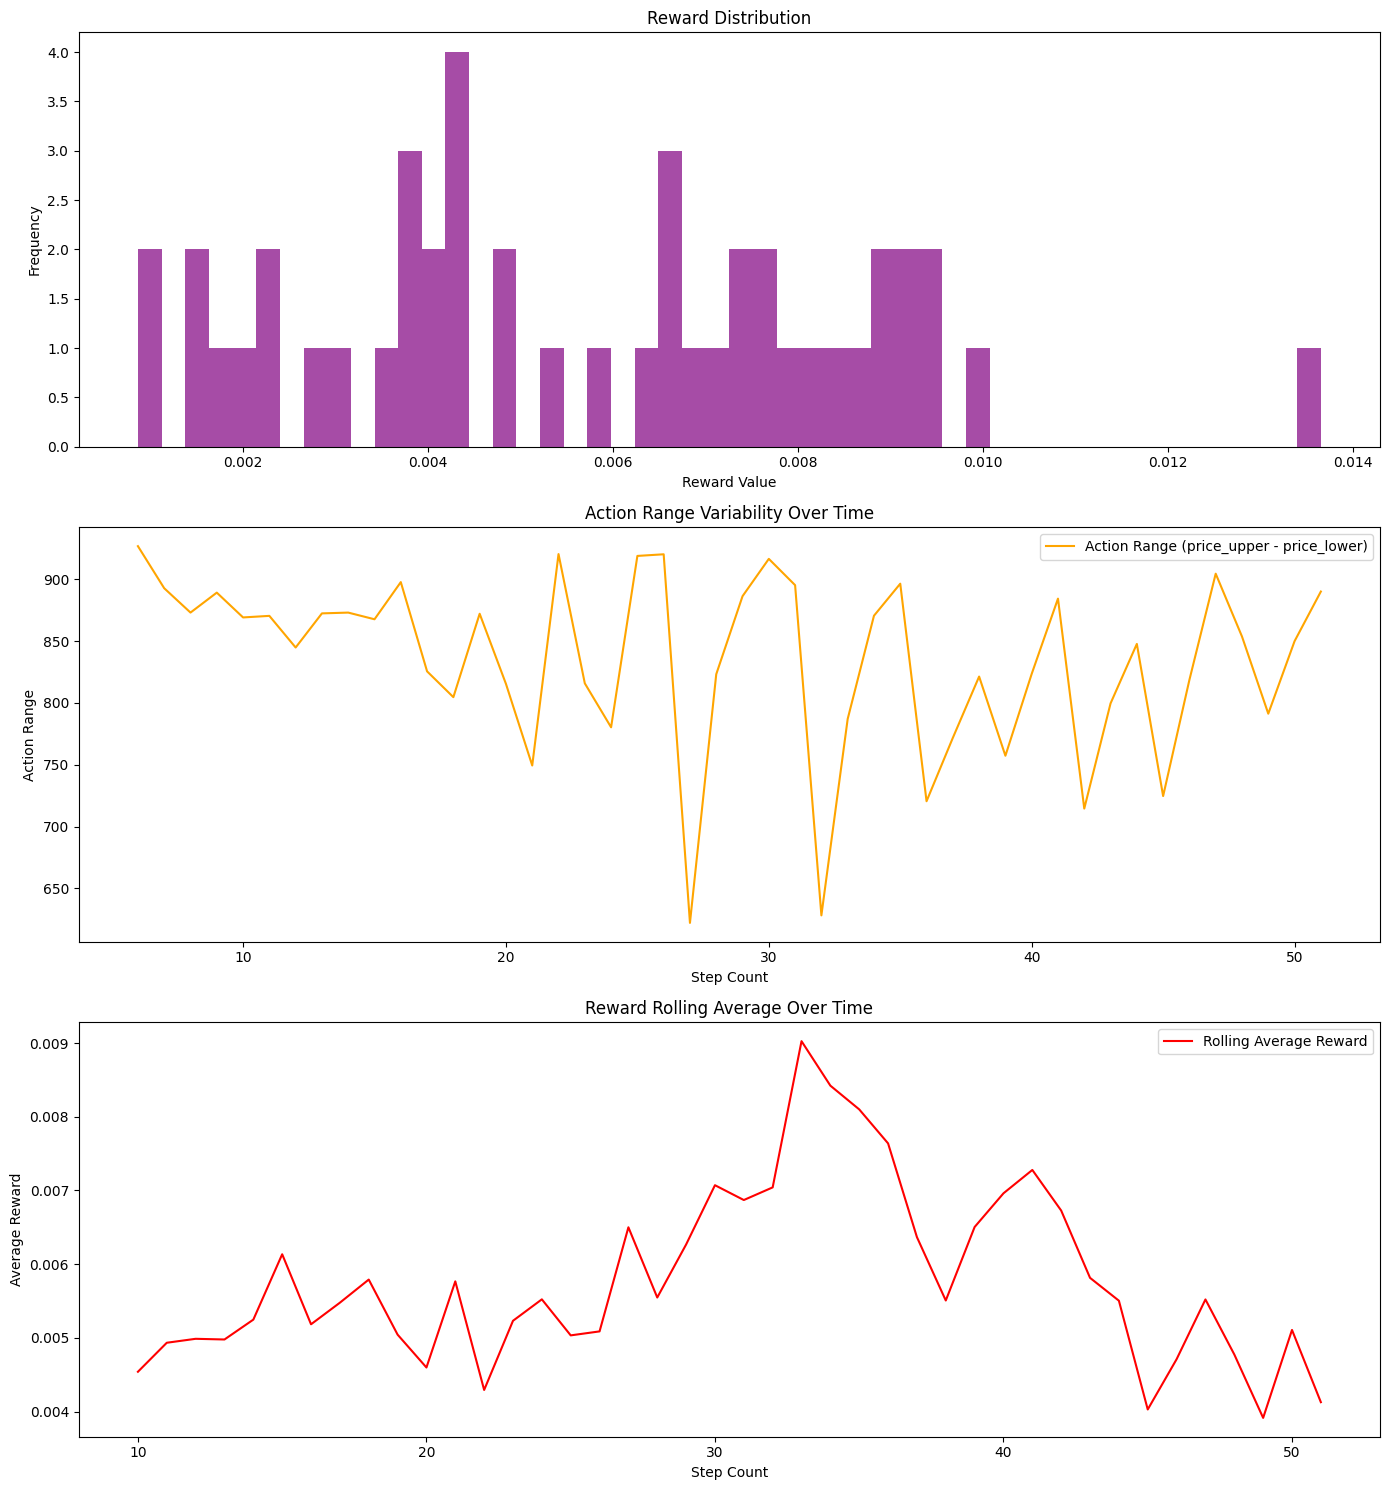

In [29]:
# Creating the other suggested plots

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15))

# Plotting the Reward Distribution
axes[0].hist(new_data_df['_reward'], bins=50, color='purple', alpha=0.7)
axes[0].set_title('Reward Distribution')
axes[0].set_xlabel('Reward Value')
axes[0].set_ylabel('Frequency')

# Plotting Action Range Variability
action_range = new_data_df['price_upper'] - new_data_df['price_lower']
axes[1].plot(new_data_df['step_count'], action_range, label='Action Range (price_upper - price_lower)', color='orange')
axes[1].set_title('Action Range Variability Over Time')
axes[1].set_xlabel('Step Count')
axes[1].set_ylabel('Action Range')
axes[1].legend()

# Plotting scaled Reward Rolling Average
rolling_avg_reward = new_data_df['_reward'].rolling(window=5).mean()
axes[2].plot(new_data_df['step_count'], rolling_avg_reward, label='Rolling Average Reward', color='red')
axes[2].set_title('Reward Rolling Average Over Time')
axes[2].set_xlabel('Step Count')
axes[2].set_ylabel('Average Reward')
axes[2].legend()


plt.tight_layout()
plt.show()


In [ ]:
  %reload_ext tensorboard

In [61]:
%load_ext tensorboard
%tensorboard --logdir ./model_storage


Launching TensorBoard...

## Predict

In [19]:
state = env.reset()
done = False
steps=5
n=0
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    n=n+1
    if n>steps:
        done=True

tf.Tensor([[0.22753789 0.14449763]], shape=(1, 2), dtype=float32)
raw_action: [[0.22753789 0.14449763]], scaled_action{'price_lower': 1178.7086, 'price_upper': 2059.1934}

{'Mint': [OrderedDict([('sender', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('owner', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('tickLower', 70740), ('tickUpper', 76320), ('amount', 52817726836484080000), ('amount0', 42180138209894123), ('amount1', 499999999999293350523)])]}
Policy returned None, no action will be taken by retail_lp wallet: 0xee1a97aA22F9aCB0034824f2A198B96BE30c3732 at this timestep.
{'Transfer': [OrderedDict([('from', '0xE0460B8E4Bd835990cd808A795F1d8D8f0BC9AC7'), ('to', '0x2929f706a936C7fDC4Ef769Ed5e12F62a22483Cc'), ('value', 1568640822919589972556)])], 'Swap': [OrderedDict([('sender', '0x2929f706a936C7fDC4Ef769Ed5e12F62a22483Cc'), ('recipient', '0x2929f706a936C7fDC4Ef769Ed5e12F62a22483Cc'), ('amount0', 819878246078369024), ('amount1', -1568640822919589972556), ('sqrtPriceX96', 346932840

## Evaluate

In [35]:
def evaluate_policy(agent, env, n_episodes=10):
    total_rewards = []
    for _ in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)  # Notice we're using the predict_policy method without exploration
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    average_reward = sum(total_rewards) / len(total_rewards)
    return average_reward

# Use the function:
average_reward = evaluate_policy(agent, env)
print(f"Average Reward over {n_episodes} episodes: {average_reward}")


{'Mint': [OrderedDict([('sender', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('owner', '0x330997E70b83f1a562490FCaA5996314fA5a971a'), ('tickLower', 75480), ('tickUpper', 80040), ('amount', 77331796873872210000), ('amount0', 362041946324940546), ('amount1', 0)])]}
{'Burn': [OrderedDict([('owner', '0x90b42A70b3811263882A80bB8642c4Ded3968E2E'), ('tickLower', 68100), ('tickUpper', 74220), ('amount', 134026468423109940000), ('amount0', 328527234837290264), ('amount1', 945340248184747340816)])]}
amount0Owed: 0, amount1Owed: 0, position_tick_lower: 68100, position_tick_upper: 74220, contract_token0_balance: 59662158754895228408, contract_token1_balance: 78353095788233272593746
{'Collect': [OrderedDict([('owner', '0x90b42A70b3811263882A80bB8642c4Ded3968E2E'), ('recipient', '0x90b42A70b3811263882A80bB8642c4Ded3968E2E'), ('tickLower', 68100), ('tickUpper', 74220), ('amount0', 0), ('amount1', 0)])]}
amount_swap:161718129147917008896 ,contract_token0 _balance: 59662158754895228408 ,contract_to